# Ultralytics YOLO as Image Feature Extractor

This notebook explores the YOLO (You Only Look Once) model from Ultralytics as a tool for feature extraction on the Yoga 107 dataset.

The YOLOv8 model (https://docs.ultralytics.com/tasks/pose/#models) is used to generate keypoints for each image (referred to here as "predictions" in the contect of this initial model). The normalized coordinates of these keypoints are flattened and then used as features to train a feed forward neural network, with each image's associated yoga pose as the target variable.

Inference is run by using the yolo model to generate the keypoints for a new image (as done here with the test data set), and then using the keypoints as inputs to the feed forward network.

Evaluation on the test dataset indicates that this approach performs similarly to the previous CNN model trained from scratch, but significantly worse than the transfer learning model. However, this approach only utilized one output format from the YOLO model, and further exploration of more sophisticated uses for these outputs could prove valuable.

Another interesting possibility would be to use both the images as input to the transfer learning model, and the data extracted by the YOLO model as input to the feed forward model; these could then be concatenated before a final output layer to produce a prediction that benefitted from both approaches.

In [ ]:
#!pip install ultralytics

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Activation, GlobalAveragePooling2D
#from keras.preprocessing.image import ImageDataGenerator
from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
from PIL import Image#, ImageFile
#ImageFile.LOAD_TRUNCATED_IMAGES = True

from ultralytics import YOLO
import random
import pickle
import torch
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Import Dataset Directly from Kaggle:
#!pip install kaggle
#!mkdir ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json

#!kaggle datasets download -d arrowe/yoga-poses-dataset-107
#!unzip /content/yoga-poses-dataset-107.zip

In [ ]:
yolo_model = YOLO("yolov8m-pose.pt")

100%|██████████| 50.8M/50.8M [00:00<00:00, 153MB/s]


In [ ]:
def yolo_predict(model, directory):
    all_results = []
    all_labels = []

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            #print(f"Predicting on images in: {subdir_path}")
            yolo_result = model.predict(source=subdir_path, save=True, conf=0.25)
            all_results.extend(yolo_result)
            all_labels.extend([subdir] * len(yolo_result))  # Repeat label for each prediction

    return all_results, all_labels

In [ ]:
train_predictions, train_labels = yolo_predict(yolo_model, "/content/107 yoga poses/train")
val_predictions, val_labels = yolo_predict(yolo_model, "/content/107 yoga poses/val")
test_predictions, test_labels = yolo_predict(yolo_model, "/content/107 yoga poses/test")

Streaming output truncated to the last 5000 lines.
image 20/47 /content/107 yoga poses/train/malasana/48-0.png: 640x448 1 person, 11.7ms
image 21/47 /content/107 yoga poses/train/malasana/49-0.png: 640x480 1 person, 12.6ms
image 22/47 /content/107 yoga poses/train/malasana/51-0.png: 640x544 1 person, 13.2ms
image 23/47 /content/107 yoga poses/train/malasana/57-0.png: 640x448 1 person, 14.7ms
image 24/47 /content/107 yoga poses/train/malasana/60-0.png: 640x352 1 person, 14.4ms
image 25/47 /content/107 yoga poses/train/malasana/61-0.png: 640x384 1 person, 11.9ms
image 26/47 /content/107 yoga poses/train/malasana/61-1.png: 640x352 1 person, 11.5ms
image 27/47 /content/107 yoga poses/train/malasana/61-3.png: 640x288 1 person, 11.7ms
image 28/47 /content/107 yoga poses/train/malasana/61-5.png: 640x480 1 person, 11.8ms
image 29/47 /content/107 yoga poses/train/malasana/65-0.png: 640x576 1 person, 11.6ms
image 30/47 /content/107 yoga poses/train/malasana/67-0.png: 640x544 1 person, 11.8ms
ima

In [ ]:
# Save each list of labels as a csv and each predictions object as a pickle

def save_labels_csv(labels, filename):
  df = pd.DataFrame(labels, columns=['label'])
  df.to_csv(filename, index=False)

def save_predictions_pickle(predictions, filename):
  with open(filename, 'wb') as f:
    pickle.dump(predictions, f)

# Save the labels and predictions
save_labels_csv(train_labels, 'train_labels.csv')
save_labels_csv(val_labels, 'val_labels.csv')
save_labels_csv(test_labels, 'test_labels.csv')

save_predictions_pickle(train_predictions, 'train_predictions.pkl')
save_predictions_pickle(val_predictions, 'val_predictions.pkl')
save_predictions_pickle(test_predictions, 'test_predictions.pkl')

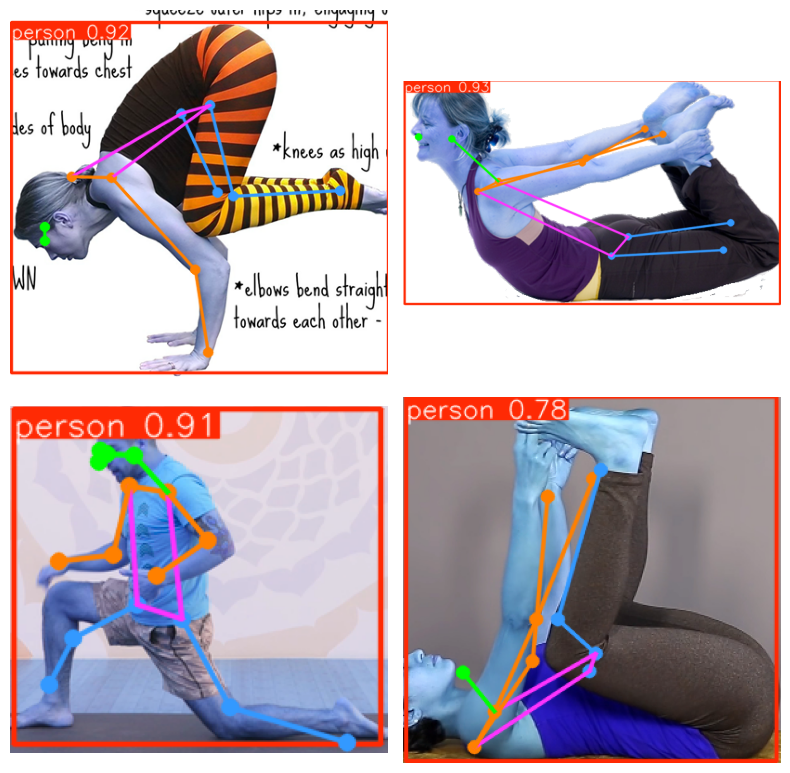

In [ ]:
# Display a sample images from the train predictions:
num_images = 4
selected_indices = random.sample(range(len(train_predictions)), num_images)

plt.figure(figsize=(8, 8))

for i, index in enumerate(selected_indices):
  result = train_predictions[index]
  image = result.plot()

  plt.subplot(2, 2, i + 1)
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def create_tf_dataset(predictions, labels, label_encoder, max_length=None): # Add max_length as parameter
    all_keypoints = []

    if max_length is None: # Calculate max_length only if not provided
        max_length = 0  # To store the maximum length encountered

        # Find the maximum length of keypoint arrays
        for prediction in predictions:
            keypoints = prediction.keypoints.xyn.cpu().numpy()
            flattened_keypoints = keypoints.reshape(-1)
            max_length = max(max_length, flattened_keypoints.shape[0])

    # Pad keypoint arrays to the maximum length
    for prediction in predictions:
        keypoints = prediction.keypoints.xyn.cpu().numpy()
        flattened_keypoints = keypoints.reshape(-1)
        # Ensure pad width is non-negative
        pad_width = (0, max(0, max_length - flattened_keypoints.shape[0]))
        padded_keypoints = np.pad(flattened_keypoints, pad_width, mode='constant')
        all_keypoints.append(padded_keypoints)

    # Convert keypoints and encoded labels to NumPy arrays explicitly
    all_keypoints = np.array(all_keypoints)
    encoded_labels = label_encoder.transform(labels)
    encoded_labels = np.array(encoded_labels)

    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((all_keypoints, encoded_labels))
    return dataset, max_length # Return max_length as well

# Ideally we would calculate max_length from training data, but that was causing issues with the val and test sets
# So for now we will set padding to 500 (which is probably overkill, but works)
train_ds, _ = create_tf_dataset(train_predictions, train_labels, label_encoder, max_length = 500)

# Use the same max_length for validation and test sets
val_ds, _ = create_tf_dataset(val_predictions, val_labels, label_encoder, max_length = 500)
test_ds, _ = create_tf_dataset(test_predictions, test_labels, label_encoder, max_length = 500)

In [ ]:
# Create a feedforward neural network to train on the new data:
model_yolo = Sequential([
    Dense(128, activation='relu', input_shape=(train_ds.element_spec[0].shape[0],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(107, activation='softmax')  # Output layer with 107 classes
])

# Compile the model
model_yolo.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history_yolo = model_yolo.fit(
    train_ds.batch(32),  # Adjust batch size as needed
    epochs=100,
    validation_data=val_ds.batch(32),
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
    ]
)

Epoch 1/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.0053 - loss: 4.7151 - val_accuracy: 0.0138 - val_loss: 4.6691 - learning_rate: 0.0010
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0548 - loss: 4.6369 - val_accuracy: 0.0173 - val_loss: 4.6681 - learning_rate: 0.0010
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0441 - loss: 4.6176 - val_accuracy: 0.0130 - val_loss: 4.6662 - learning_rate: 0.0010
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0407 - loss: 4.6297 - val_accuracy: 0.0112 - val_loss: 4.6607 - learning_rate: 0.0010
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0267 - loss: 4.6224 - val_accuracy: 0.0147 - val_loss: 4.6490 - learning_rate: 0.0010
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0321 - loss: 4.6122 - val_accuracy: 0.0156 - val_loss: 4.6311 - learning_rate: 0.0010
Epoch 7/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0217 - loss: 4

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model_yolo.evaluate(test_ds.batch(32))
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3294 - loss: 2.5536
Test Loss: 2.5713
Test Accuracy: 0.3217
